In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate,GridSearchCV

In [2]:
#Loading FIles 
Data = pd.read_csv(r"C:\Users\tammy\Downloads\category_tree.csv")
Data.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [3]:
Event = pd.read_csv(r"C:\Users\tammy\Downloads\events.csv\events.csv")
Event.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
Item_Prop_1 = pd.read_csv(r"C:\Users\tammy\Downloads\item_properties_part1.csv\item_properties_part1.csv")
Item_Prop_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [5]:
Item_Prop_2 = pd.read_csv(r"C:\Users\tammy\Downloads\item_properties_part2.csv\item_properties_part2.csv")
Item_Prop_2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [6]:
#Concating Item_Prop_1 and Item_Prop_2 into a single dataFrame
Item_Prop = pd.concat([Item_Prop_1, Item_Prop_2])
Item_Prop.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [7]:
#view the shape of the various data sets
Event.shape

(2756101, 5)

In [8]:
Data.shape

(1669, 2)

In [9]:
Item_Prop_1.shape

(10999999, 4)

In [10]:
Item_Prop_2.shape

(9275903, 4)

In [11]:
Item_Prop.shape

(20275902, 4)

In [12]:
Data.isnull().sum()

categoryid     0
parentid      25
dtype: int64

In [13]:
#checking for duplicates
print(Data.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
1664    False
1665    False
1666    False
1667    False
1668    False
Length: 1669, dtype: bool


In [14]:
#Dropping na values  in Data
Data.dropna(axis=0)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [15]:
#Checking for missing values
Event.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [16]:
#Checking for missing values
Item_Prop.isnull().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [17]:
#Checking the data types in each dataset
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [18]:
Event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [19]:
Item_Prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [20]:
#Event Count
event_count = Event.event.value_counts()
event_count

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [21]:
#Event count
event_percentage =(event_count/len(Event))*100
event_percentage 

event
view           96.669607
addtocart       2.515583
transaction     0.814810
Name: count, dtype: float64

In [22]:
#Grouping by Transcations
Event.groupby('event')['transactionid'].count()

event
addtocart          0
transaction    22457
view               0
Name: transactionid, dtype: int64

In [23]:
#Groouping by visitor Id
Event.groupby('event')['visitorid'].count()

event
addtocart        69332
transaction      22457
view           2664312
Name: visitorid, dtype: int64

In [24]:
#Removing duplicates 

#Printing the number of rows before removng duplicates
print('Number of rows before removing duplicates:', Event.shape[0])

#Remove duplicates based on all columns
Event.drop_duplicates(inplace=True)

#Print the number of rows after removing duplicates
print('Number of rows after removing duplicates: ', Event.shape[0])

Number of rows before removing duplicates: 2756101
Number of rows after removing duplicates:  2755641


In [25]:
#Changing the dates from Unisex time to readable time
Event['date_time'] = pd.to_datetime(Event['timestamp'], unit = 'ms')
Event['date_time']

0         2015-06-02 05:02:12.117
1         2015-06-02 05:50:14.164
2         2015-06-02 05:13:19.827
3         2015-06-02 05:12:35.914
4         2015-06-02 05:02:17.106
                    ...          
2756096   2015-08-01 03:13:05.939
2756097   2015-08-01 03:30:13.142
2756098   2015-08-01 02:57:00.527
2756099   2015-08-01 03:08:50.703
2756100   2015-08-01 03:36:03.914
Name: date_time, Length: 2755641, dtype: datetime64[ns]

In [26]:
Event.head(20)    

,timestamp,visitorid,event,itemid,transactionid,date_time
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106
5,1433224086234,972639,view,22556,NaN,2015-06-02 05:48:06.234
6,1433221923240,810725,view,443030,NaN,2015-06-02 05:12:03.240
7,1433223291897,794181,view,439202,NaN,2015-06-02 05:34:51.897
8,1433220899221,824915,view,428805,NaN,2015-06-02 04:54:59.221
9,1433221204592,339335,view,82389,NaN,2015-06-02 05:00:04.592


In [27]:
#checking how many times a customer view an item before making purchase decision
item_transaction = Event[['visitorid', 'itemid', 'date_time']][Event['event']=='transaction']
print(item_transaction.head().reset_index())

item_view = Event[['visitorid', 'itemid', 'date_time']][Event['event']=='view']
print(item_view.head().reset_index())

#customer added item to cart
item_addtocart =Event[['visitorid', 'itemid', 'date_time']][Event['event']=='addtocart']
print(item_transaction.head().reset_index())


   index  visitorid  itemid               date_time
0    130     599528  356475 2015-06-02 05:17:56.276
1    304     121688   15335 2015-06-01 21:18:20.981
2    418     552148   81345 2015-06-01 21:25:15.008
3    814     102019  150318 2015-06-01 16:38:56.375
4    843     189384  310791 2015-06-01 16:01:58.180
   index  visitorid  itemid               date_time
0      0     257597  355908 2015-06-02 05:02:12.117
1      1     992329  248676 2015-06-02 05:50:14.164
2      2     111016  318965 2015-06-02 05:13:19.827
3      3     483717  253185 2015-06-02 05:12:35.914
4      4     951259  367447 2015-06-02 05:02:17.106
   index  visitorid  itemid               date_time
0    130     599528  356475 2015-06-02 05:17:56.276
1    304     121688   15335 2015-06-01 21:18:20.981
2    418     552148   81345 2015-06-01 21:25:15.008
3    814     102019  150318 2015-06-01 16:38:56.375
4    843     189384  310791 2015-06-01 16:01:58.180


In [29]:
#Checking to see how many visitorid and itemid was foun in all three events
M_events=item_transaction.merge(item_addtocart, on=['visitorid','itemid'],how ='inner' , suffixes=['(transaction)','(addtocart)'])
M_events=M_events.merge(item_view, on=['visitorid','itemid'],how ='inner',suffixes =['(view)'])
M_events=M_events.rename(columns={'date_time' : 'date_time (view)'})
M_events.head(50)

,visitorid,itemid,date_time(transaction),date_time(addtocart),date_time (view)
0,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-02 05:11:36.102
1,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-03 02:12:25.235
2,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-06 21:10:10.602
3,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-08 02:44:57.480
4,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 00:34:37.794
5,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 00:34:09.376
6,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 18:22:47.121
7,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 18:17:39.198
8,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 19:05:02.402
9,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 21:57:42.396


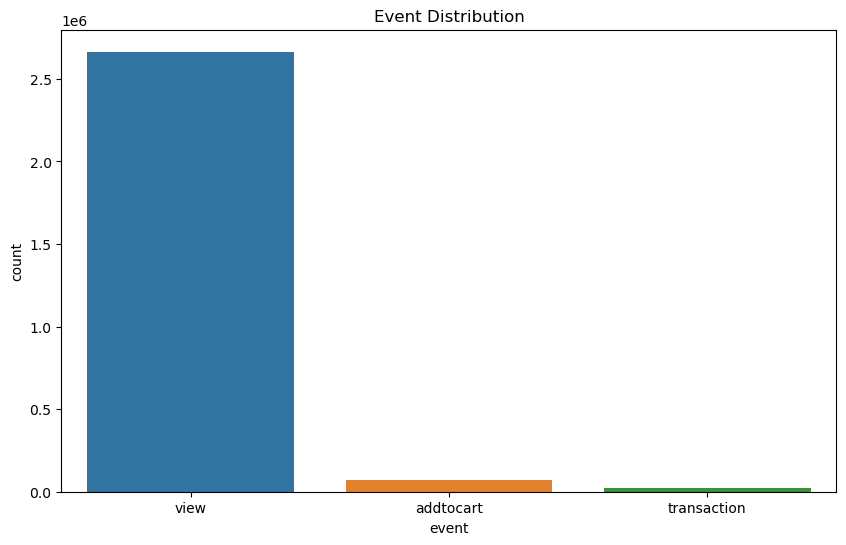

In [31]:
#Event Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=Event, x='event')
plt.title('Event Distribution')
plt.show()

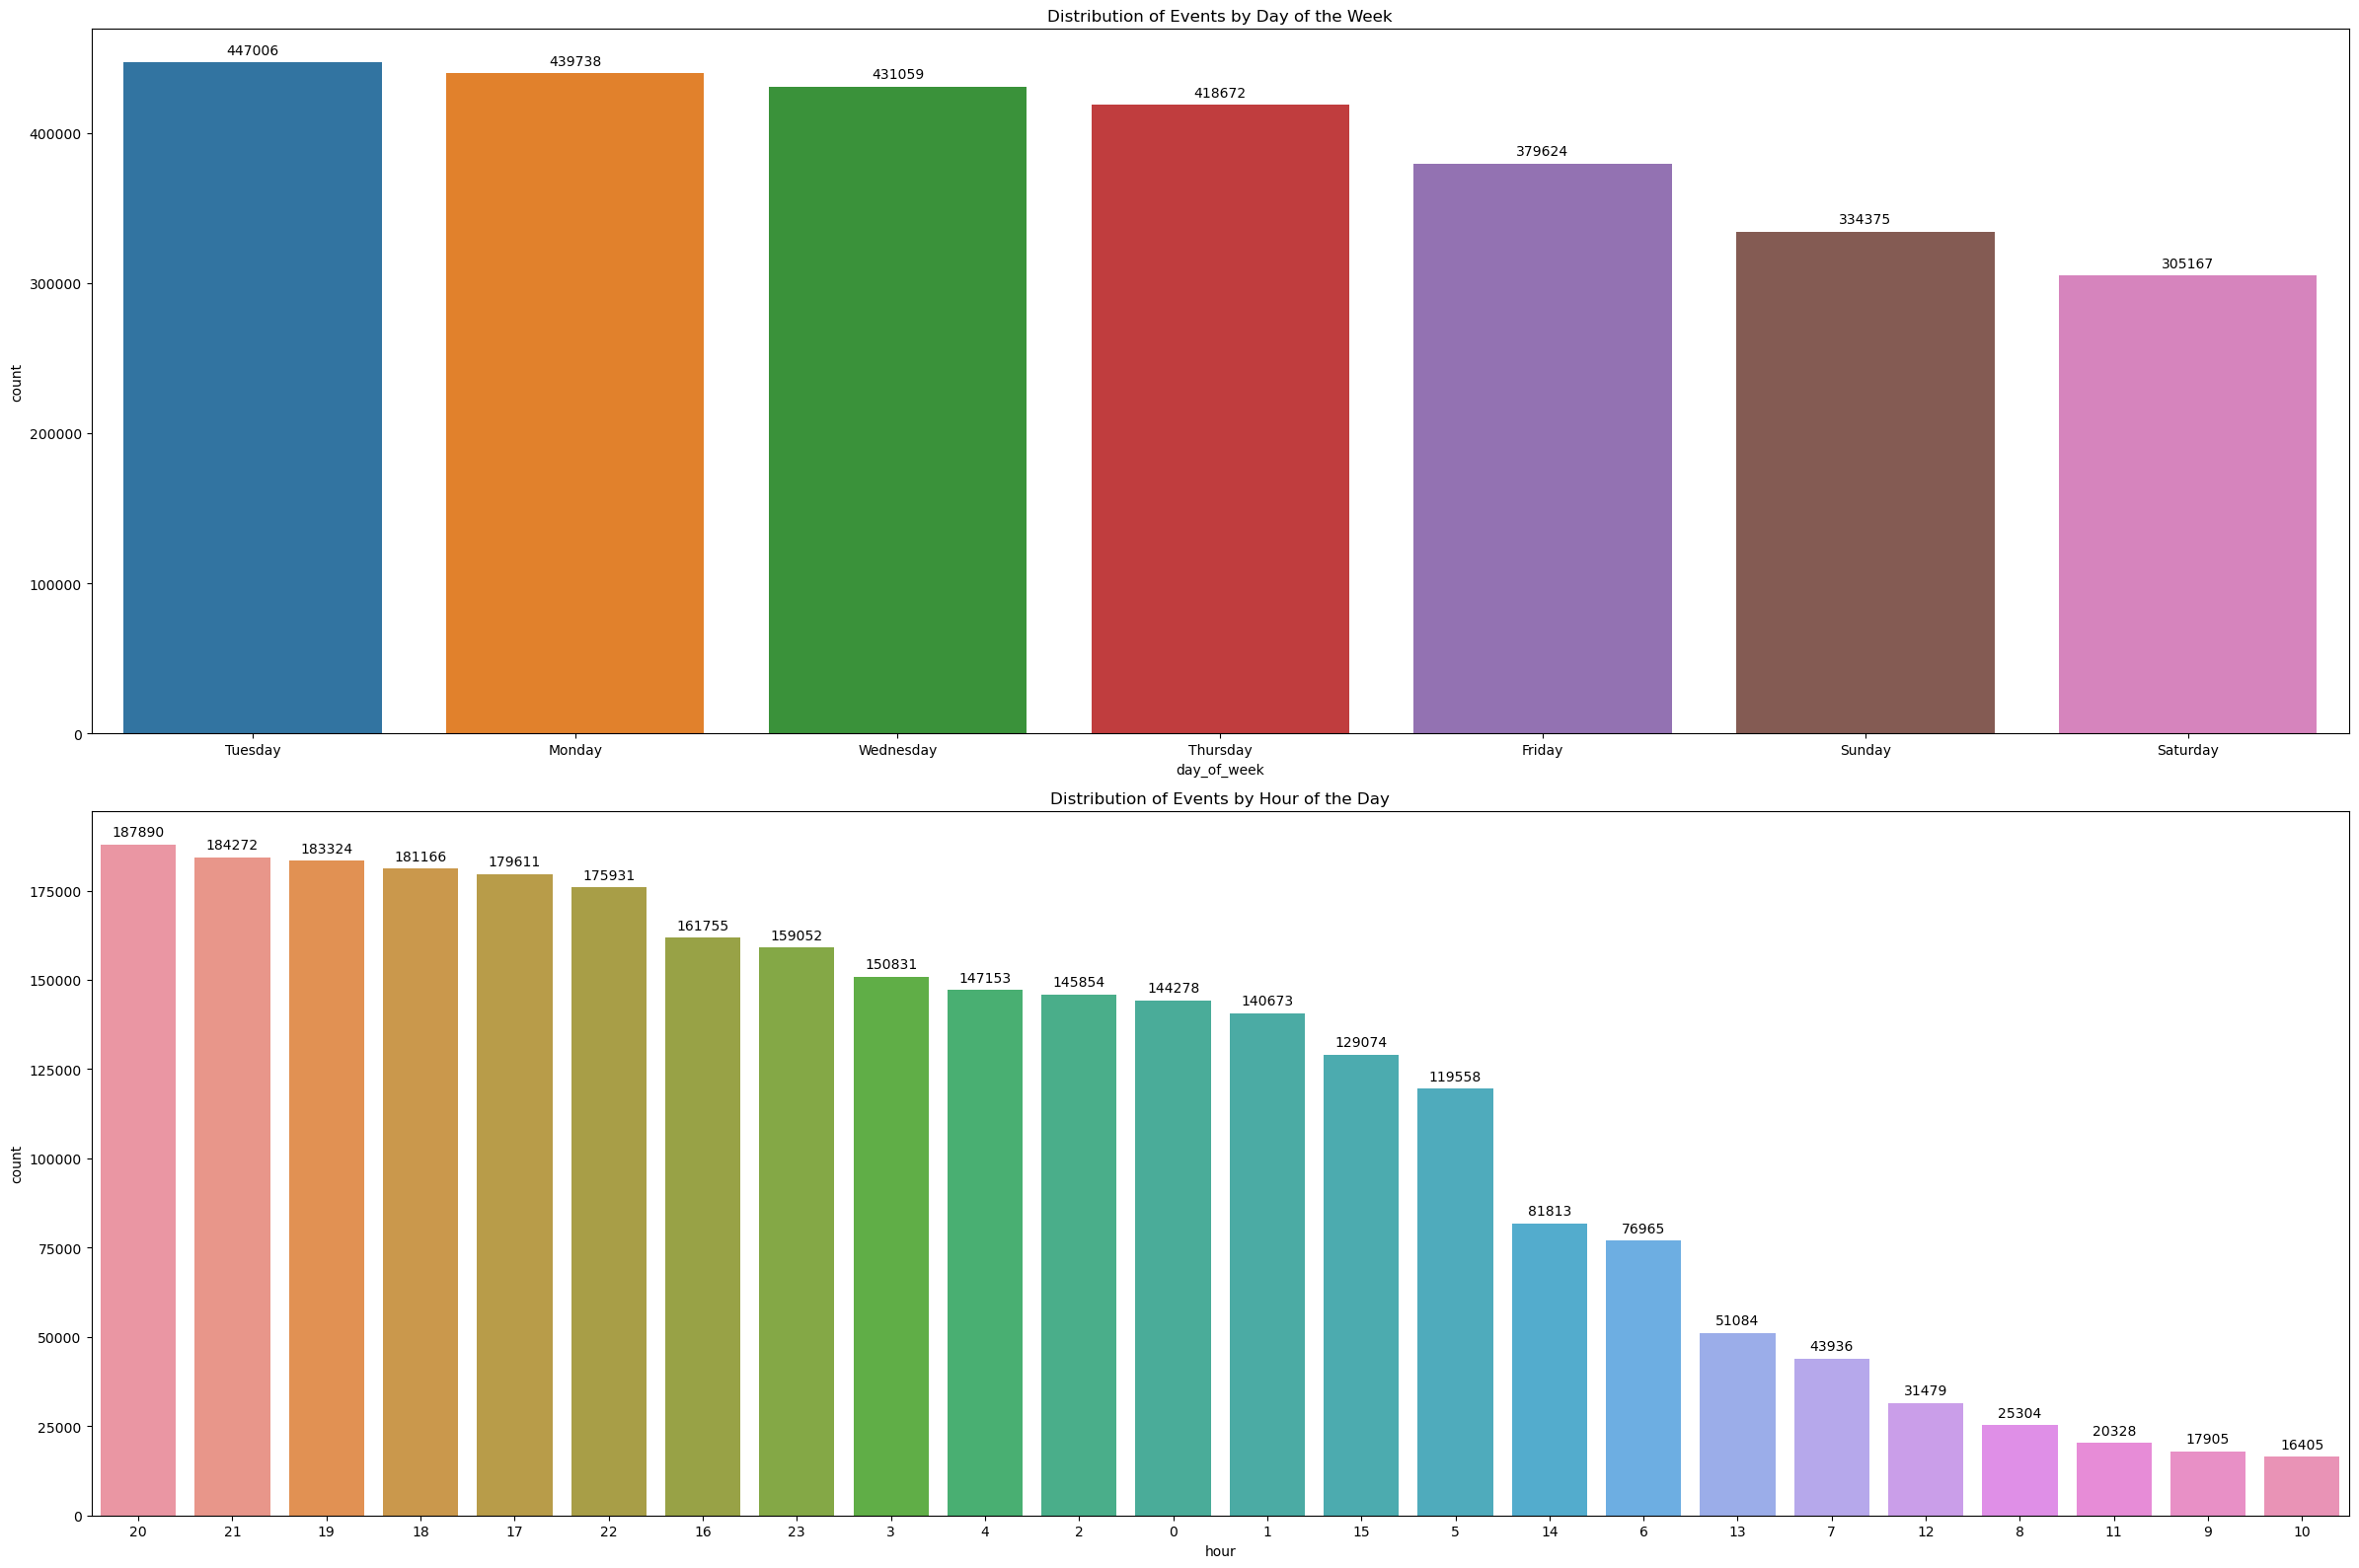

In [33]:
 # distribution of events by day of the week and hour of the day. Showing the views only 
Event['day_of_week'] = Event['date_time'].dt.day_name()
Event['hour'] = Event['date_time'].dt.hour

plt.figure(figsize=(24, 16))

plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=Event, x='day_of_week', order=Event['day_of_week'].value_counts().index)
plt.title('Distribution of Events by Day of the Week')
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=Event, x='hour', order=Event['hour'].value_counts().index)
plt.title('Distribution of Events by Hour of the Day')
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [34]:
# Events over time
events_daily = Event.resample('D', on='date_time').count()
events_daily

,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour
date_time,,,,,,,
2015-05-03,13682,13682,13682,13682,83,13682,13682
2015-05-04,19413,19413,19413,19413,154,19413,19413
2015-05-05,23011,23011,23011,23011,225,23011,23011
2015-05-06,23920,23920,23920,23920,258,23920,23920
2015-05-07,23157,23157,23157,23157,217,23157,23157
...,...,...,...,...,...,...,...
2015-09-14,20905,20905,20905,20905,154,20905,20905
2015-09-15,20425,20425,20425,20425,158,20425,20425
2015-09-16,11494,11494,11494,11494,137,11494,11494


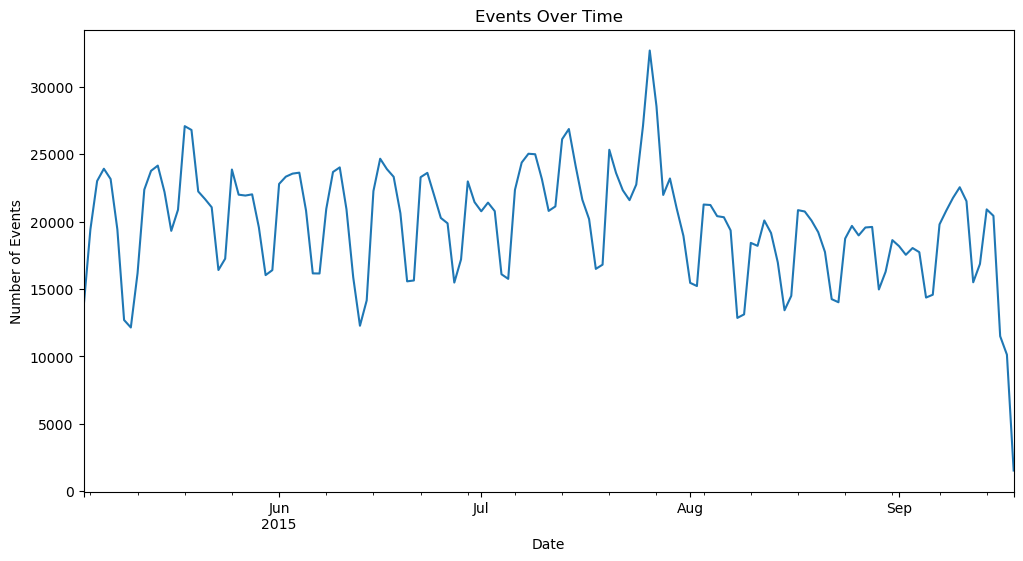

In [35]:
# Events over time plot

plt.figure(figsize=(12, 6))
events_daily['event'].plot()
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
Name: count, dtype: int64


Text(0, 0.5, 'number of event')

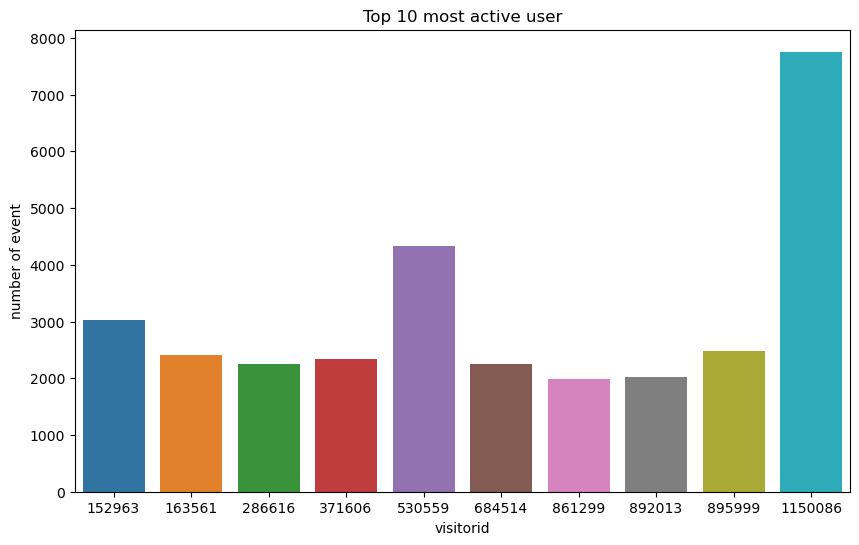

In [36]:
#most Active users
top_most_active_user=Event['visitorid'].value_counts().head(10)
print(top_most_active_user)
plt.figure(figsize=(10,6))
sns.barplot(x=top_most_active_user.index,y=top_most_active_user.values)
plt.title('Top 10 most active user')
plt.xlabel('visitorid')
plt.ylabel('number of event')

itemid
187946    3410
461686    2538
5411      2325
370653    1854
219512    1740
298009    1642
96924     1633
309778    1565
257040    1531
384302    1528
Name: count, dtype: int64


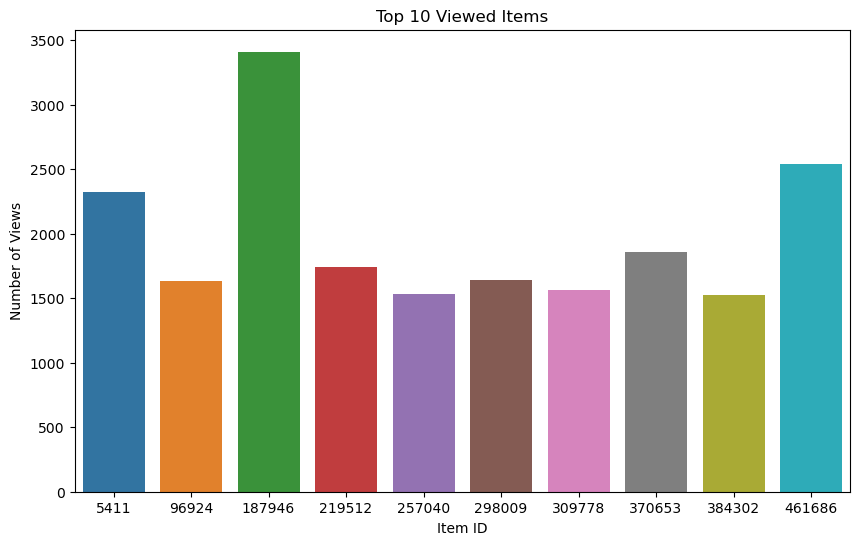

In [37]:
# Top items by views
top_viewed_items = Event[Event['event'] == 'view']['itemid'].value_counts().head(10)
print(top_viewed_items)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

itemid
461686    133
119736     97
213834     92
312728     46
7943       46
445351     45
48030      41
420960     38
248455     38
17478      37
Name: count, dtype: int64


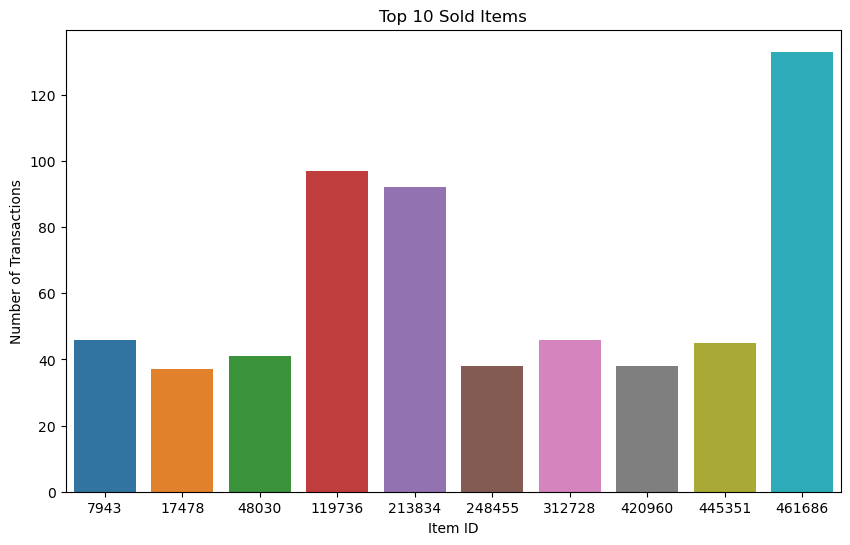

In [38]:
#  Top items by transactions
top_sold_items = Event[Event['event'] == 'transaction']['itemid'].value_counts().head(10)
print(top_sold_items)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values)
plt.title('Top 10 Sold Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Transactions')
plt.show()

itemid
461686    304
312728    161
409804    152
320130    141
29196     135
7943       97
48030      95
441852     90
445351     89
257040     89
Name: count, dtype: int64


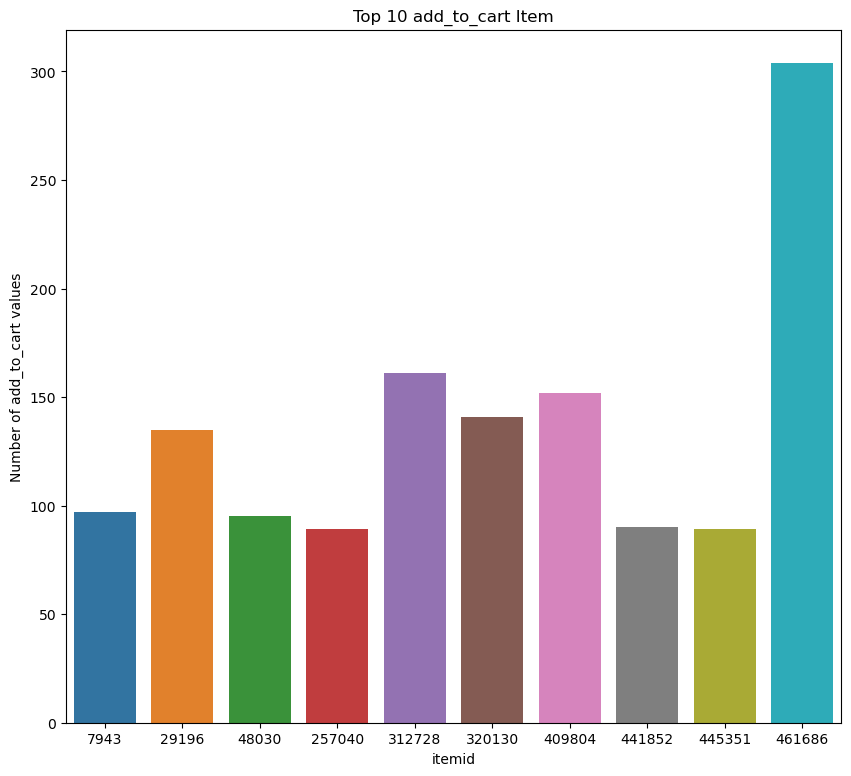

In [39]:
# Top item by addtocart
top_addtocart_item =Event[Event['event']=='addtocart']['itemid'].value_counts().head(10)
print(top_addtocart_item)

plt.figure(figsize=(10,9))
sns.barplot(x=top_addtocart_item.index ,y =top_addtocart_item.values)
plt.title('Top 10 add_to_cart Item')
plt.xlabel('itemid')
plt.ylabel('Number of add_to_cart values')

plt.show()

In [41]:
Data.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [46]:
#Merge events with item properties and Data dataframe
merged_events = Event.merge(Item_Prop,on=['itemid','timestamp'],how='left')
merged_events.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN


In [47]:
merged_events=merged_events.merge(Data, left_on='property', right_on='categoryid', how='left')
merged_events.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN,NaN,NaN


In [48]:
# Top categories by views
top_categories_views = merged_events[merged_events['event'] == 'view']['parentid'].value_counts().head(10)

if not top_categories_views.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_views.index, y=top_categories_views.values)
    plt.title('Top 10 Categories by Views')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Views')
    plt.show()
else:
    print("No data available for Top Categories by Views")

No data available for Top Categories by Views


In [49]:
#Top categories by transactions
top_categories_transactions = merged_events[merged_events['event'] == 'transaction']['parentid'].value_counts().head(10)

if not top_categories_transactions.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_transactions.index, y=top_categories_transactions.values)
    plt.title('Top 10 Categories by Transactions')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Transactions')
    plt.show()
else:
    print("No data available for Top Categories by Transactions")

No data available for Top Categories by Transactions


   visitorid  itemid  property  parentid
0          0       3         0         0
1          1       1         0         0
2          2       8         0         0
3          3       1         0         0
4          4       1         0         0
          itemid  property  parentid
itemid       1.0       NaN       NaN
property     NaN       NaN       NaN
parentid     NaN       NaN       NaN


C:\Users\tammy\anaconda3\ANACONDA\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


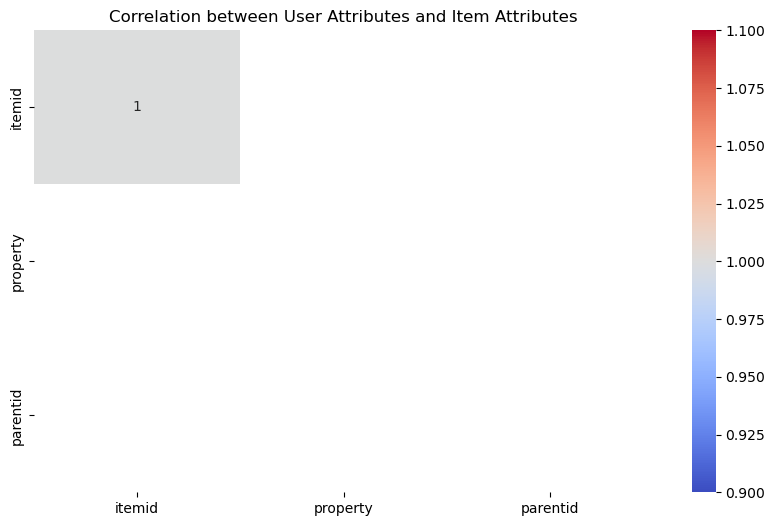

In [50]:
#Correlation between user attributes and item attributes
user_item_merged = merged_events.groupby('visitorid').agg({
    'itemid': 'count',
    'property': 'nunique',
    'parentid': 'nunique',
})
print(user_item_merged.head().reset_index())

correlation_matrix = user_item_merged.corr()
print(correlation_matrix)

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot =True,cmap ='coolwarm')
plt.title('Correlation between User Attributes and Item Attributes')
plt.show()

In [51]:
#Add-to-cart to transaction conversion rate

add_to_cart = Event[Event['event'] == 'addtocart']
transactions = Event[Event['event'] == 'transaction']
conversion_rate = len(transactions) / len(add_to_cart)

print(f"Add-to-cart to transaction conversion rate: {conversion_rate:.2%}")

Add-to-cart to transaction conversion rate: 32.56%


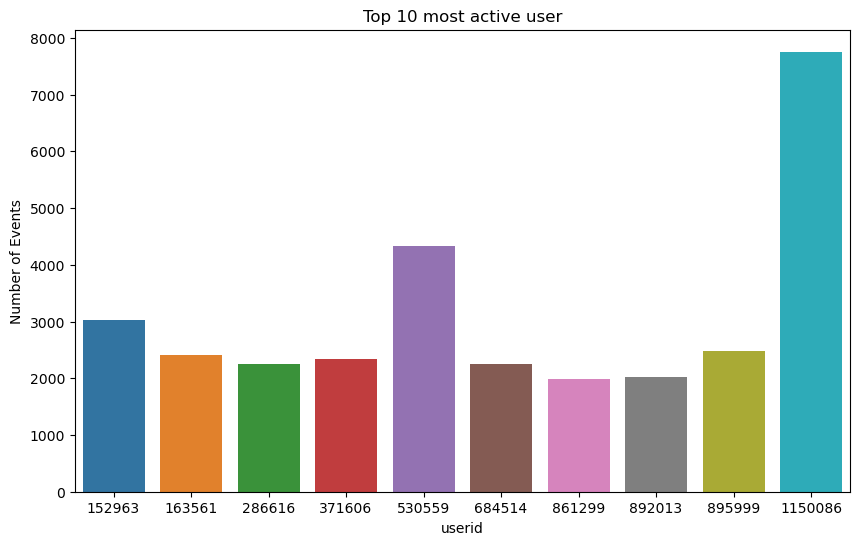

In [53]:
# Most active users
top_active_user = Event['visitorid'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_active_user.index,y=top_active_user.values)
plt.title('Top 10 most active user')
plt.xlabel('userid')
plt.ylabel('Number of Events')
plt.show()

In [56]:
#Feature Engineering
df = merged_events.copy()

In [57]:
df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN,NaN,NaN


In [58]:
df.shape

(2755641, 12)

In [59]:
#taking a sample from the dataframe
np.random.seed(1)

rows_to_keep = np.random.choice(df.index, size=100000, replace=False)
sample_df = df.loc[rows_to_keep]

# Display the sampled DataFrame
sample_df

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
1502186,1430801768576,1163548,view,182851,NaN,2015-05-05 04:56:08.576,Tuesday,4,NaN,NaN,NaN,NaN
547399,1435378506816,519492,view,287287,NaN,2015-06-27 04:15:06.816,Saturday,4,NaN,NaN,NaN,NaN
2152452,1436078633332,532358,view,347081,NaN,2015-07-05 06:43:53.332,Sunday,6,NaN,NaN,NaN,NaN
1508392,1430851366672,1394708,view,354881,NaN,2015-05-05 18:42:46.672,Tuesday,18,NaN,NaN,NaN,NaN
628172,1438579567615,1174103,view,78887,NaN,2015-08-03 05:26:07.615,Monday,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
603512,1435694949972,692135,view,404825,NaN,2015-06-30 20:09:09.972,Tuesday,20,NaN,NaN,NaN,NaN
751354,1439099414315,722421,view,137144,NaN,2015-08-09 05:50:14.315,Sunday,5,NaN,NaN,NaN,NaN
649947,1438624688773,1144723,view,62228,NaN,2015-08-03 17:58:08.773,Monday,17,NaN,NaN,NaN,NaN
2334499,1436820023832,448128,view,260819,NaN,2015-07-13 20:40:23.832,Monday,20,NaN,NaN,NaN,NaN


In [60]:
sample_df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
1502186,1430801768576,1163548,view,182851,NaN,2015-05-05 04:56:08.576,Tuesday,4,NaN,NaN,NaN,NaN
547399,1435378506816,519492,view,287287,NaN,2015-06-27 04:15:06.816,Saturday,4,NaN,NaN,NaN,NaN
2152452,1436078633332,532358,view,347081,NaN,2015-07-05 06:43:53.332,Sunday,6,NaN,NaN,NaN,NaN
1508392,1430851366672,1394708,view,354881,NaN,2015-05-05 18:42:46.672,Tuesday,18,NaN,NaN,NaN,NaN
628172,1438579567615,1174103,view,78887,NaN,2015-08-03 05:26:07.615,Monday,5,NaN,NaN,NaN,NaN


In [61]:
 #feature engineering 
#user_based Feature

user_behavior = sample_df.groupby('visitorid').agg({
    'itemid':'count',
    'property': 'nunique',
    'parentid':'nunique',
    'timestamp': ['min' ,'max','mean']
}).reset_index()

user_behavior.columns = ['visitorid', 'item_count', 'property_count', 'category_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
user_behavior['time_on_platform'] = user_behavior['last_interaction'] - user_behavior['first_interaction']
user_behavior['time_between_actions'] = user_behavior['time_on_platform'] / (user_behavior['item_count'] - 1)

user_behavior

,visitorid,item_count,property_count,category_count,first_interaction,last_interaction,avg_interaction_time,time_on_platform,time_between_actions
0,2,1,0,0,1438970905669,1438970905669,1.438971e+12,0,NaN
1,6,1,0,0,1440914628202,1440914628202,1.440915e+12,0,NaN
2,88,1,0,0,1442086733371,1442086733371,1.442087e+12,0,NaN
3,120,1,0,0,1436023859041,1436023859041,1.436024e+12,0,NaN
4,137,1,0,0,1433149153810,1433149153810,1.433149e+12,0,NaN
...,...,...,...,...,...,...,...,...,...
87717,1407491,1,0,0,1441657541978,1441657541978,1.441658e+12,0,NaN
87718,1407494,1,0,0,1434394598580,1434394598580,1.434395e+12,0,NaN
87719,1407504,1,0,0,1439656228164,1439656228164,1.439656e+12,0,NaN
87720,1407530,1,0,0,1437964161007,1437964161007,1.437964e+12,0,NaN


In [62]:
#item_based feature
item_popularity = sample_df.groupby('itemid').agg({
    'visitorid':'count',
     'event': ['nunique',lambda  x : sum(x == 'view'),
              lambda x:sum(x =='addtocart'),
              lambda x:sum(x =='transaction')]
   }).reset_index()

item_popularity.columns=['itemid','user_count','event_count','view_count','addtocart_count','transaction_count']
item_popularity['conversion rate'] = item_popularity['transaction_count']/item_popularity['addtocart_count']
item_popularity

,itemid,user_count,event_count,view_count,addtocart_count,transaction_count,conversion rate
0,3,1,1,1,0,0,NaN
1,6,1,1,1,0,0,NaN
2,15,1,1,0,1,0,0.0
3,19,2,1,2,0,0,NaN
4,32,3,1,3,0,0,NaN
...,...,...,...,...,...,...,...
50079,466857,1,1,1,0,0,NaN
50080,466858,1,1,1,0,0,NaN
50081,466860,1,1,1,0,0,NaN
50082,466861,1,1,1,0,0,NaN


In [63]:
#user_item interaction feature
user_item_interaction = sample_df.groupby(['visitorid' ,'itemid']).agg({
    'event':'count',
    'timestamp' : ['min' ,'max']
    }).reset_index()
user_item_interaction.columns =['visitorid','itemid' ,'interaction_count','first_interaction','last_interaction']
user_item_interaction['time_between_interaction'] = user_item_interaction['last_interaction'] -user_item_interaction['first_interaction']
user_item_interaction

,visitorid,itemid,interaction_count,first_interaction,last_interaction,time_between_interaction
0,2,342816,1,1438970905669,1438970905669,0
1,6,65273,1,1440914628202,1440914628202,0
2,88,58827,1,1442086733371,1442086733371,0
3,120,153339,1,1436023859041,1436023859041,0
4,137,383819,1,1433149153810,1433149153810,0
...,...,...,...,...,...,...
97972,1407491,445239,1,1441657541978,1441657541978,0
97973,1407494,3125,1,1434394598580,1434394598580,0
97974,1407504,406296,1,1439656228164,1439656228164,0
97975,1407530,455539,1,1437964161007,1437964161007,0


In [64]:
user_feature=user_behavior.drop(['first_interaction' ,'last_interaction'],axis=1)
item_feature=item_popularity.drop(['view_count','addtocart_count','transaction_count'],axis=1)
user_item_interaction_feature=user_item_interaction.drop(['first_interaction','last_interaction'],axis=1)

#merge the feature into single dataframe, preparing features for a machine learning model by combining information from different DataFrames 

features=user_item_interaction_feature.merge(user_feature,on ='visitorid').merge(item_feature, on ='itemid')

In [65]:
features.head()

,visitorid,itemid,interaction_count,time_between_interaction,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,2,342816,1,0,1,0,0,1.438971e+12,0,NaN,6,1,NaN
1,228860,342816,1,0,1,0,0,1.437159e+12,0,NaN,6,1,NaN
2,916244,342816,1,0,1,0,0,1.433721e+12,0,NaN,6,1,NaN
3,1059763,342816,1,0,2,0,0,1.432230e+12,197097,197097.0,6,1,NaN
4,1148730,342816,1,0,1,0,0,1.432776e+12,0,NaN,6,1,NaN


In [66]:
import random 

# Replace infinity values with NaN
features=features.replace([np.inf,-np.inf],np.nan)

# Fill NaN values with the median
features=features.fillna(features.median())
features.head(10)

,visitorid,itemid,interaction_count,time_between_interaction,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,2,342816,1,0,1,0,0,1.438971e+12,0,4.087350e+07,6,1,0.0
1,228860,342816,1,0,1,0,0,1.437159e+12,0,4.087350e+07,6,1,0.0
2,916244,342816,1,0,1,0,0,1.433721e+12,0,4.087350e+07,6,1,0.0
3,1059763,342816,1,0,2,0,0,1.432230e+12,197097,1.970970e+05,6,1,0.0
4,1148730,342816,1,0,1,0,0,1.432776e+12,0,4.087350e+07,6,1,0.0
5,1264860,342816,1,0,1,0,0,1.430862e+12,0,4.087350e+07,6,1,0.0
6,6,65273,1,0,1,0,0,1.440915e+12,0,4.087350e+07,42,2,0.0
7,19033,65273,1,0,1,0,0,1.441406e+12,0,4.087350e+07,42,2,0.0
8,172280,65273,1,0,1,0,0,1.437916e+12,0,4.087350e+07,42,2,0.0
9,173863,65273,1,0,37,0,0,1.440536e+12,4049600794,1.124889e+08,42,2,0.0


In [68]:
# Data preprocessing
# Split the data

train_data ,test_data = train_test_split(features,test_size =0.2,random_state=42)

# Normalize the features
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

In [69]:
# Collaborative filtering using matrix factorization (SVD)
reader = Reader(rating_scale =(0,1))
train_dataset=Dataset.load_from_df(train_data[['visitorid' ,'itemid','interaction_count']],reader)

# covert train_dataset into specific format
trainset=train_dataset.build_full_trainset()

In [70]:
#perform hyperparameter tuning for an SVD (Singular Value Decomposition) recommendation model using grid search. 

param_grid = {'n_factors': [10, 50, 100], 'n_epochs': [20, 50], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

In [72]:
# fits the GridSearchCV object to the training dataset
gs.fit(train_dataset)

In [73]:
# Best hyperparameters
best_params = gs.best_params['rmse']
print(f"best hyperparameter for RSME :{best_params}")

best hyperparameter for RSME :{'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.1}


In [74]:
# Train the model with the best hyperparameters
algo =SVD(n_factors=best_params['n_factors'],n_epochs=best_params['n_epochs'],lr_all=best_params['lr_all'],reg_all=best_params['reg_all'])
algo.fit(trainset)

#model evalution
testset=list(zip(test_data['visitorid'].values, test_data['itemid'].values, test_data['interaction_count'].values))
prediction=algo.test(testset)

In [75]:
# Calculate evaluation metrics
MAE = mean_absolute_error(test_data['interaction_count'],[pred.est for pred in prediction])
MSE = mean_squared_error(test_data['interaction_count'],[pred.est for pred in prediction])
rmse = np.sqrt(MSE)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.020643768202398625
Mean Squared Error: 0.03193887284807233
Root Mean Squared Error: 0.17871450094514527
